In [96]:
from pathlib import Path
import json
try:
    import yaml
except ImportError:
    yaml = None


from datasets import load_dataset
BASE_DIR = Path("/home/lfy/BRIDGE/IRT")
VERIFIED_RESULTS_DIR = BASE_DIR / "experiments" / "evaluation" / "verified"
BASH_ONLY_RESULTS_DIR = BASE_DIR / "experiments" / "evaluation" / "bash-only"

def read_jsonl(path: Path):
    """Load every JSON line into a list of dicts."""
    with path.open() as f:
        return [json.loads(line) for line in f]

def select_score(value):
    if isinstance(value, dict):
        for key in ("any_medal", "valid_submission", "above_median"):
            if key in value:
                return value[key]
        raise ValueError(f"Unable to pick score from {value}")
    return value

def build_score_matrix(records):
    required = {"id", "model_name", "score"}
    for idx, record in enumerate(records):
        missing = required - record.keys()
        if missing:
            raise ValueError(f"Record {idx} is missing fields: {missing}")
    ids = sorted({record["id"] for record in records})
    models = sorted({record["model_name"] for record in records})
    id_to_idx = {rid: idx for idx, rid in enumerate(ids)}
    model_to_idx = {name: idx for idx, name in enumerate(models)}
    matrix = [[float("nan") for _ in models] for _ in ids]
    for record in records:
        row = id_to_idx[record["id"]]
        col = model_to_idx[record["model_name"]]
        matrix[row][col] = select_score(record["score"])
    return {"ids": ids, "models": models, "array": matrix}

def load_verified_difficulties(dataset_id="princeton-nlp/SWE-bench_Verified", split="test"):
    dataset = load_dataset(dataset_id, split=split)
    return {row["instance_id"]: row.get("difficulty") for row in dataset}

swe_results = read_jsonl(BASE_DIR / "data/swebench_results.jsonl")
mle_results = read_jsonl(BASE_DIR / "data/mlebench_results.jsonl")

# U
swe_scores = build_score_matrix(swe_results)
mle_scores = build_score_matrix(mle_results)

# M
print(f"SWE-bench: {len(swe_scores['ids'])} ids x {len(swe_scores['models'])} models")
print("SWE models (M):", swe_scores["models"])
print(f"MLE-bench: {len(mle_scores['ids'])} ids x {len(mle_scores['models'])} models")
print("MLE models (M):", mle_scores["models"])

difficulty_lookup = load_verified_difficulties()
swe_difficulty = [difficulty_lookup.get(task_id) for task_id in swe_scores["ids"]]
missing = sum(d is None for d in swe_difficulty)
print("Missing difficulties:", missing)
difficulty_levels = [ '<15 min fix', '15 min - 1 hour', '1-4 hours', '>4 hours']
difficulty_to_int = {label: idx + 1 for idx, label in enumerate(difficulty_levels)}
swe_difficulty_ints = [difficulty_to_int.get(label) for label in swe_difficulty]
print("Difficulty mapping:", difficulty_to_int)
print("Example mapped integers:", swe_difficulty_ints[:5])

SWE-bench: 500 ids x 6 models
SWE models (M): ['gpt-oss-120b', 'gpt-oss-20b', 'minimaxm2', 'qwen2_5coder32b', 'qwen3-coder-30b', 'qwen3-coder-480b']
MLE-bench: 37 ids x 5 models
MLE models (M): ['gpt-oss-120b', 'gpt-oss-20b', 'minimaxm2', 'qwen3-coder-30b', 'qwen3coder480']
Missing difficulties: 0
Difficulty mapping: {'<15 min fix': 1, '15 min - 1 hour': 2, '1-4 hours': 3, '>4 hours': 4}
Example mapped integers: [2, 2, 2, 3, 2]


In [97]:
from collections import Counter

all_runs_path = BASE_DIR / "data" / "all_runs.jsonl"
all_models = Counter()
with all_runs_path.open() as f:
    for line in f:
        payload = json.loads(line)
        model_name = payload.get("model")
        if model_name:
            all_models[model_name] += 1

print(f"Found {len(all_models)} unique models in {all_runs_path}.")
for model_name, count in sorted(all_models.items()):
    print(f"  {model_name}: {count} rows")


Found 15 unique models in /home/lfy/BRIDGE/IRT/data/all_runs.jsonl.
  claude-3-5-sonnet-20240620: 1378 rows
  claude-3-5-sonnet-20241022: 1384 rows
  claude-3-7-sonnet-20250219: 1344 rows
  claude-3-opus: 1371 rows
  gpt-3: 1469 rows
  gpt-3.5-turbo-instruct: 1037 rows
  gpt-4-0125: 1379 rows
  gpt-4-0314: 1279 rows
  gpt-4-1106: 1376 rows
  gpt-4-turbo: 1372 rows
  gpt-4o-2024-05-13: 1362 rows
  gpt2: 746 rows
  human: 793 rows
  o1: 1337 rows
  o1-preview: 1337 rows


In [98]:
import math

def matrix_to_pyirt_records(scores):
    ids = scores["ids"]
    models = scores["models"]
    arr = scores["array"]
    for col_idx, model in enumerate(models):
        responses = {}
        for row_idx, item in enumerate(ids):
            value = arr[row_idx][col_idx]
            if value is None or isinstance(value, float) and math.isnan(value):
                continue
            responses[item] = int(value)  # py-irt expects binary outcomes
        if responses:
            yield {"subject_id": model, "responses": responses}

def write_pyirt_jsonl(scores, out_path):
    records = list(matrix_to_pyirt_records(scores))
    with open(out_path, "w") as f:
        for record in records:
            f.write(json.dumps(record) + "\n")
    print(f"Wrote {len(records)} subjects to {out_path}")


In [99]:
write_pyirt_jsonl(swe_scores, BASE_DIR / "data/swebench_pyirt.jsonl")
write_pyirt_jsonl(mle_scores, BASE_DIR / "data/mlebench_pyirt.jsonl")

Wrote 6 subjects to /home/lfy/BRIDGE/IRT/data/swebench_pyirt.jsonl
Wrote 5 subjects to /home/lfy/BRIDGE/IRT/data/mlebench_pyirt.jsonl


In [100]:
def _tokenize_verified_keywords(*values):
    """Return normalized keyword tokens used for filtering."""
    tokens = set()
    for value in values:
        if not value:
            continue
        lowered = str(value).strip().lower()
        if not lowered:
            continue
        tokens.add(lowered)
        cleaned = lowered.replace('/', ' ').replace('+', ' ').replace('-', ' ').replace('_', ' ')
        for part in cleaned.split():
            part = part.strip()
            if len(part) < 3:
                continue
            tokens.add(part)
    return tokens


def _load_run_metadata(entry):
    metadata = {}
    for name in ("metadata.yaml", "metadata.yml"):
        meta_path = entry / name
        if meta_path.exists() and yaml is not None:
            try:
                metadata = yaml.safe_load(meta_path.read_text()) or {}
            except Exception as exc:
                print(f"Warning: unable to parse {meta_path}: {exc}")
            break
    return metadata


def _load_run_success_ids(entry, verified_task_ids=None):
    results_path = entry / "results" / "results.json"
    success_ids = None
    if results_path.exists():
        with results_path.open() as f:
            payload = json.load(f)
        success_ids = set(payload.get("resolved") or [])
    else:
        per_instance_path = entry / "per_instance_details.json"
        if per_instance_path.exists():
            with per_instance_path.open() as f:
                payload = json.load(f)
            success_ids = {
                task_id
                for task_id, details in payload.items()
                if isinstance(details, dict) and details.get("resolved")
            }
    if success_ids is None:
        return None
    if verified_task_ids is not None:
        success_ids &= verified_task_ids
    return success_ids


def load_verified_runs(
    verified_root=VERIFIED_RESULTS_DIR,
    *,
    extra_roots=None,
    verified_task_ids=None,
):
    """Load metadata and resolved ids for every verified evaluation run."""
    runs = []
    verified_root = Path(verified_root)
    if not verified_root.exists():
        raise FileNotFoundError(f"No verified directory found at {verified_root}")
    roots = [verified_root]
    if extra_roots:
        for root in extra_roots:
            root_path = Path(root)
            if root_path.exists():
                roots.append(root_path)
    verified_task_ids = set(verified_task_ids) if verified_task_ids is not None else None
    seen = set()
    for root in roots:
        for entry in sorted(root.iterdir()):
            if not entry.is_dir():
                continue
            run_id = entry.name
            if run_id in seen:
                continue
            success_ids = _load_run_success_ids(entry, verified_task_ids)
            if success_ids is None:
                continue
            metadata = _load_run_metadata(entry)
            tags = metadata.get("tags") or {}
            info = metadata.get("info") or {}
            model_tags = tags.get("model") or []
            org = tags.get("org")
            label = info.get("name") or run_id
            keywords = _tokenize_verified_keywords(run_id, label, org, *model_tags)
            search_terms = [run_id, label]
            if isinstance(org, (list, tuple, set)):
                search_terms.extend(org)
            else:
                search_terms.append(org)
            search_terms.extend(model_tags or [])
            search_text = " ".join(
                str(term).strip().lower() for term in search_terms if term
            ).strip()
            runs.append(
                {
                    "run_id": run_id,
                    "label": label,
                    "org": org,
                    "model_tags": model_tags,
                    "keywords": keywords,
                    "search_text": search_text,
                    "success_ids": success_ids,
                    "success_count": len(success_ids),
                }
            )
            seen.add(run_id)
    return runs


def build_verified_keyword_index(runs):
    """Map every keyword to the run ids where it appears."""
    keyword_index = {}
    for run in runs:
        for keyword in run["keywords"]:
            keyword_index.setdefault(keyword, set()).add(run["run_id"])
    return {key: sorted(ids) for key, ids in keyword_index.items()}


def select_verified_runs(runs, include_keywords=None):
    """Filter runs whose metadata contains any of the provided keywords."""
    if not include_keywords:
        return runs
    include = [token.lower() for token in include_keywords]
    selected = []
    for run in runs:
        haystack = run["search_text"]
        if any(token in haystack for token in include):
            selected.append(run)
    return selected


def _pick_best_runs_by_label(runs):
    """Return the highest scoring run per model label."""
    best = {}
    for run in runs:
        label = run["label"]
        current = best.get(label)
        if current is None or run["success_count"] > current["success_count"]:
            best[label] = run
    return sorted(best.values(), key=lambda run: (-run["success_count"], run["run_id"]))


def build_verified_records(runs, base_ids, selection_filters=None, verbose=False):
    """Convert verified success ids into py-irt friendly records."""
    base_ids = list(base_ids)
    base_set = set(base_ids)
    if selection_filters:
        pool = []
        for label, filters in selection_filters.items():
            matches = select_verified_runs(runs, filters)
            if verbose:
                print(f"[verified] {label}: matched {len(matches)} run(s)")
            pool.extend(matches)
    else:
        pool = list(runs)
    if not pool:
        return []
    unique_runs = {}
    for run in pool:
        unique_runs.setdefault(run["run_id"], run)
    best_runs = _pick_best_runs_by_label(unique_runs.values())
    records = []
    for run in best_runs:
        success_ids = set(run["success_ids"]) & base_set
        if not success_ids:
            if verbose:
                print(f"[verified] {run['run_id']}: no overlapping successes; skipping")
            continue
        if verbose:
            print(
                f"[verified] Keeping run {run['run_id']} ({run['label']}) "
                f"with {len(success_ids)} SWE successes"
            )
        for task_id in base_ids:
            records.append(
                {
                    "id": task_id,
                    "model_name": run["run_id"],
                    "score": 1 if task_id in success_ids else 0,
                }
            )
    return records

def _coerce_mapping_flag(value, default=True):
    if isinstance(value, bool):
        return value
    if value is None:
        return default
    text = str(value).strip().lower()
    if not text:
        return default
    if text in {"1", "t", "true", "y", "yes"}:
        return True
    if text in {"0", "f", "false", "n", "no"}:
        return False
    return default


def normalize_model_mapping(mapping):
    """Normalize the editable mapping dict before saving/using it."""
    normalized = {}
    mapping = mapping or {}
    for model_key, spec in mapping.items():
        key = str(model_key).strip()
        if not key:
            continue
        spec = spec or {}
        alias = spec.get("alias") or spec.get("display_name") or key
        runs = spec.get("run_ids") or spec.get("runs") or spec.get("run_names") or []
        if isinstance(runs, dict):
            run_values = runs.keys()
        elif isinstance(runs, (list, tuple, set)):
            run_values = runs
        else:
            run_values = [runs]
        normalized_runs = []
        seen = set()
        for run_id in run_values:
            run_text = str(run_id).strip()
            if not run_text or run_text in seen:
                continue
            seen.add(run_text)
            normalized_runs.append(run_text)
        normalized[key] = {
            "alias": str(alias).strip() or key,
            "plot": _coerce_mapping_flag(spec.get("plot"), True),
            "selected": _coerce_mapping_flag(spec.get("selected"), True),
            "run_ids": normalized_runs,
        }
    return normalized


def build_verified_records_from_mapping(
    runs,
    mapping,
    base_ids,
    *,
    selected_only=False,
    verbose=False,
):
    """Convert verified successes into py-IRT rows based on the curated mapping."""
    mapping = mapping or {}
    if not mapping:
        return [], []
    run_lookup = {run["run_id"]: run for run in runs}
    base_ids = list(base_ids)
    missing_runs = []
    records = []
    kept_models = 0
    for model_key, spec in mapping.items():
        if selected_only and not spec.get("selected", True):
            continue
        run_ids = spec.get("run_ids") or []
        combined_success = set()
        for run_id in run_ids:
            run = run_lookup.get(run_id)
            if not run:
                missing_runs.append(run_id)
                continue
            combined_success.update(run["success_ids"])
        if not combined_success:
            if verbose:
                print(f"[verified] {model_key}: no overlapping successes; skipping")
            continue
        kept_models += 1
        if verbose:
            print(
                f"[verified] {model_key}: keeping {len(combined_success)} successes "
                f"from {len(run_ids)} run(s)"
            )
        for task_id in base_ids:
            records.append(
                {
                    "id": task_id,
                    "model_name": model_key,
                    "score": 1 if task_id in combined_success else 0,
                }
            )
    if verbose:
        print(
            f"[verified] built {kept_models} model column(s) "
            f"(selected_only={selected_only})"
        )
    if missing_runs and verbose:
        print(
            "[verified] missing run directories:",
            ", ".join(sorted(set(missing_runs))),
        )
    return records, sorted(set(missing_runs))



In [101]:
MODEL_MAPPING_PATH = BASE_DIR / "data" / "model_run_mapping.json"

# Update this dictionary so each key matches the `model` column from all_runs.jsonl.
MODEL_RUN_MAPPING = {
    "claude-3-5-sonnet-20241022": {
        "alias": "Claude 3.5 Sonnet (New)",
        "plot": True,
        "selected": True,
        "run_ids": ["20241029_OpenHands-CodeAct-2.1-sonnet-20241022",],
    },
    "gemini-3-pro-preview": {
        "alias": "Gemini 3 Pro (preview)",
        "plot": True,
        "selected": True,
        "run_ids": ["20251120_livesweagent_gemini-3-pro-preview"],
    },
    "claude-4-sonnet-20250514": {
        "alias": "Claude 4 Sonnet",
        "plot": True,
        "selected": True,
        "run_ids": ["20250720_Lingxi-v1.5_claude-4-sonnet-20250514"],
    },
    "gpt-5-2025-08-07": {
        "alias": "GPT 5",
        "plot": True,
        "selected": True,
        "run_ids": ["20251015_Prometheus_v1.2.1_gpt5"],
    },
    "claude-4.5-opus-medium": {
        "alias": "Claude 4.5 Opus medium (20251101)",
        "plot": True,
        "selected": True,
        "run_ids": ["20251124_mini-v1.16.0_claude-opus-4-5-20251101"],
    },
    "kimi-k2": {
        "alias": "Kimi K2",
        "plot": True,
        "selected": True,
        "run_ids": ["20251014_Lingxi_kimi_k2"],
    },
    "claude-4.5-sonnet-250929": {
        "alias": "Claude 4.5 Sonnet",
        "plot": True,
        "selected": True,
        "run_ids": ["20250929_mini-v1.13.3_sonnet-4-5-20250929"],
    },
    "qwen3-coder-480b-a25b-instruct": {
        "alias": "Qwen3 Coder 480B Instruct",
        "plot": True,
        "selected": True,
        "run_ids": ["20250805_openhands-Qwen3-Coder-480B-A35B-Instruct"],
    },
    "glm-4.6": {
        "alias": "GLM 4.6",
        "plot": True,
        "selected": True,
        "run_ids": ["20250930_zai_glm4-6"],
    },
    "claude-3-7-sonnet-20250219": {
        "alias": "Claude 3.7 Sonnet",
        "plot": True,
        "selected": True,
        "run_ids": ["20250415_openhands"],
    },
    "claude-4-opus-20250514": {
        "alias": "Claude 4 Opus",
        "plot": True,
        "selected": True,
        "run_ids": ["20250802_mini-v1.0.0_claude-4-opus-20250514"],
    },
    "minimaxm2": {
        "alias": "Minimax M2",
        "plot": True,
        "selected": True,
        "run_ids": ["minimaxm2"],
    },
    "o4-mini": {
        "alias": "o4 mini",
        "plot": True,
        "selected": True,
        "run_ids": ["20250503_patchpilot-v1.1-o4-mini"],
    },
    "glm-4.5": {
        "alias": "GLM 4.5",
        "plot": True,
        "selected": True,
        "run_ids": ["20250728_zai_glm4-5"],
    },
    "deepseek-v3.2-reasoner": {
        "alias": "Deepseek v3.2 reasoner",
        "plot": True,
        "selected": True,
        "run_ids": ["20251201_mini-v1.17.1_deepseek-v3.2-reasoner"],
    },
    "entrpo-ekto-30b": {
        "alias": "EntroPO-EKTO-30B",
        "plot": True,
        "selected": True,
        "run_ids": ["20250901_entroPO_R2E_QwenCoder30BA3B"],
    },
    "gpt-5-mini": {
        "alias": "GPT 5 Mini",
        "plot": True,
        "selected": True,
        "run_ids": ["20250807_mini-v1.7.0_gpt-5-mini"],
    },
    "gpt-5-nano": {
        "alias": "GPT 5 Nano",
        "plot": True,
        "selected": True,
        "run_ids": ["20250807_mini-v1.7.0_gpt-5-nano"],
    },
    "o3-2025-04-16": {
        "alias": "o3",
        "plot": True,
        "selected": True,
        "run_ids": ["20250726_mini-v1.0.0_o3-2025-04-16"],
    },
    "frogboss-32b-2510": {
        "alias": "FrogBoss 32B",
        "plot": True,
        "selected": True,
        "run_ids": ["20251110_frogboss-32b"],
    },
    "gemini-2.5-pro": {
        "alias": "",
        "plot": True,
        "selected": True,
        "run_ids": ["20250726_mini-v1.0.0_gemini-2.5-pro"],
    },
    "qwen3-coder-30b-a3b-instruct": {
        "alias": "Qwen 3 Coder 30B Instruct",
        "plot": True,
        "selected": True,
        "run_ids": ["20250805_openhands-Qwen3-Coder-30B-A3B-Instruct"],
    },
    "o3-mini": {
        "alias": "o3 mini",
        "plot": True,
        "selected": True,
        "run_ids": ["20250214_agentless_lite_o3_mini"],
    },
    "gpt-4.1-2025-04-14": {
        "alias": "GPT 4.1",
        "plot": True,
        "selected": True,
        "run_ids": ["20250720_mini-v0.0.0_gpt-4.1-mini-2025-04-14"],
    },
    "gpt-4o-2024-05-13": {
        "alias": "GPT 4o (2024-05-13)",
        "plot": True,
        "selected": True,
        "run_ids": ["20241028_agentless-1.5_gpt4o"],
    },
    "gpt-4-1106": {
        "alias": "GPT-4 1106",
        "plot": True,
        "selected": True,
        "run_ids": ["20240402_sweagent_gpt4"],
    },
    "gpt-4o-2024-11-20": {
        "alias": "GPT 4o (2024-11-20)",
        "plot": True,
        "selected": True,
        "run_ids": ["20250720_mini-v0.0.0-gpt-4o-2024-11-20"],
    },
    "claude-3-opus": {
        "alias": "Claude 3 Opus",
        "plot": True,
        "selected": True,
        "run_ids": ["20240402_sweagent_claude3opus"],
    },
    "qwen2.5-coder-32b-inst": {
        "alias": "Qwen 2.5 Coder 32B Instruct",
        "plot": True,
        "selected": True,
        "run_ids": ["20250803_mini-v1.0.0_qwen2-5-coder-32b-instruct"],
    },
    "claude-3-5-sonnet-20240620": {
        "alias": "Claude 3.5 Sonnet (Old)",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "gpt-4-0314": {
        "alias": "GPT-4 0314",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "gpt-4-0125": {
        "alias": "GPT-4 0125",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "gpt-4-turbo": {
        "alias": "GPT 4 Turbo",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "gpt-3.5-turbo-instruct": {
        "alias": "GPT 3.5 Turbo Instruct",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "gpt-3": {
        "alias": "gpt-3",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "o1-preview": {
        "alias": "o1 preview",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "o1": {
        "alias": "o1",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    "gpt2": {
        "alias": "GPT 2",
        "plot": True,
        "selected": True,
        "run_ids": [],
    },
    # "MODEL_KEY_PLACEHOLDER_30": {
    #     "alias": "",
    #     "plot": True,
    #     "selected": True,
    #     "run_ids": [],
    # },
}

if MODEL_MAPPING_PATH.exists() and not MODEL_RUN_MAPPING:
    MODEL_RUN_MAPPING = json.loads(MODEL_MAPPING_PATH.read_text())

MODEL_RUN_MAPPING = normalize_model_mapping(MODEL_RUN_MAPPING)
print(f"Configured {len(MODEL_RUN_MAPPING)} model(s) in MODEL_RUN_MAPPING.")
if MODEL_RUN_MAPPING:
    print("Models:", ", ".join(sorted(MODEL_RUN_MAPPING)))


Configured 38 model(s) in MODEL_RUN_MAPPING.
Models: claude-3-5-sonnet-20240620, claude-3-5-sonnet-20241022, claude-3-7-sonnet-20250219, claude-3-opus, claude-4-opus-20250514, claude-4-sonnet-20250514, claude-4.5-opus-medium, claude-4.5-sonnet-250929, deepseek-v3.2-reasoner, entrpo-ekto-30b, frogboss-32b-2510, gemini-2.5-pro, gemini-3-pro-preview, glm-4.5, glm-4.6, gpt-3, gpt-3.5-turbo-instruct, gpt-4-0125, gpt-4-0314, gpt-4-1106, gpt-4-turbo, gpt-4.1-2025-04-14, gpt-4o-2024-05-13, gpt-4o-2024-11-20, gpt-5-2025-08-07, gpt-5-mini, gpt-5-nano, gpt2, kimi-k2, minimaxm2, o1, o1-preview, o3-2025-04-16, o3-mini, o4-mini, qwen2.5-coder-32b-inst, qwen3-coder-30b-a3b-instruct, qwen3-coder-480b-a25b-instruct


In [102]:
extra_verified_roots = [BASH_ONLY_RESULTS_DIR]
verified_runs = load_verified_runs(
    extra_roots=extra_verified_roots,
    verified_task_ids=set(swe_scores["ids"]),
)
root_summary = ", ".join(str(root) for root in [VERIFIED_RESULTS_DIR] + extra_verified_roots if Path(root).exists())
print(f"Discovered {len(verified_runs)} verified run directories from: {root_summary}.")
if not verified_runs:
    raise RuntimeError("No verified runs found; ensure VERIFIED_RESULTS_DIR is correct.")

print("Example verified runs:")
for run in verified_runs[:5]:
    print(f"  {run['run_id']} -> {run['label']} ({run['success_count']} successes)")
if len(verified_runs) > 5:
    print("  ...")

verified_keyword_index = build_verified_keyword_index(verified_runs)
keyword_counts = sorted(verified_keyword_index.items(), key=lambda kv: (-len(kv[1]), kv[0]))
print("Keyword options (top 15 by coverage):")
for keyword, run_ids in keyword_counts[:15]:
    print(f"  {keyword}: {len(run_ids)} run(s)")
if len(keyword_counts) > 15:
    print(f"  ... ({len(keyword_counts)} total keywords)")

verified_model_tag_options = {}
for run in verified_runs:
    for tag in run["model_tags"]:
        verified_model_tag_options.setdefault(tag.lower(), set()).add(run["run_id"])
verified_model_tag_options = {tag: sorted(run_ids) for tag, run_ids in verified_model_tag_options.items()}
if verified_model_tag_options:
    model_tag_summary = sorted(verified_model_tag_options.items(), key=lambda kv: (-len(kv[1]), kv[0]))
    print("Model tag options (top 10):")
    for tag, run_ids in model_tag_summary[:10]:
        print(f"  {tag}: {len(run_ids)} run(s)")

if not MODEL_RUN_MAPPING:
    print("MODEL_RUN_MAPPING is empty; update the mapping cell above before exporting verified data.")
else:
    MODEL_MAPPING_PATH.write_text(json.dumps(MODEL_RUN_MAPPING, indent=2, sort_keys=True))
    print(f"Saved mapping to {MODEL_MAPPING_PATH}")

    verified_run_records, missing_runs = build_verified_records_from_mapping(
        verified_runs,
        MODEL_RUN_MAPPING,
        swe_scores["ids"],
        verbose=True,
    )
    if missing_runs:
        print("Missing directories from mapping:", ", ".join(missing_runs))

    if verified_run_records:
        verified_scores = build_score_matrix(verified_run_records)
        write_pyirt_jsonl(verified_scores, BASE_DIR / "data" / "swebench_verified_pyirt.jsonl")
        print("Verified run columns:", verified_scores["models"])
    else:
        print("No verified run records were built. Update MODEL_RUN_MAPPING.")

    selected_run_records, _ = build_verified_records_from_mapping(
        verified_runs,
        MODEL_RUN_MAPPING,
        swe_scores["ids"],
        selected_only=True,
        verbose=False,
    )
    if selected_run_records:
        verified_selected_scores = build_score_matrix(selected_run_records)
        write_pyirt_jsonl(
            verified_selected_scores,
            BASE_DIR / "data" / "swebench_verified_selected_pyirt.jsonl",
        )
        print("Selected verified columns:", verified_selected_scores["models"])
    else:
        print("No selected verified records were built.")



Discovered 152 verified run directories from: /home/lfy/BRIDGE/IRT/experiments/evaluation/verified, /home/lfy/BRIDGE/IRT/experiments/evaluation/bash-only.
Example verified runs:
  20231010_rag_claude2 -> RAG + Claude 2 (22 successes)
  20231010_rag_gpt35 -> RAG + ChatGPT 3.5 (2 successes)
  20231010_rag_swellama13b -> RAG + SWE-Llama 13B (6 successes)
  20231010_rag_swellama7b -> RAG + SWE-Llama 7B (7 successes)
  20240402_rag_claude3opus -> RAG + Claude 3 Opus (35 successes)
  ...
Keyword options (top 15 by coverage):
  claude: 57 run(s)
  sonnet: 51 run(s)
  agent: 37 run(s)
  gpt: 35 run(s)
  mini: 29 run(s)
  swe: 26 run(s)
  20241022: 23 run(s)
  claude-3-5-sonnet-20241022: 21 run(s)
  (2024: 18 run(s)
  (2025: 16 run(s)
  20250514: 16 run(s)
  2024: 14 run(s)
  3.5: 11 run(s)
  instruct: 11 run(s)
  preview: 11 run(s)
  ... (839 total keywords)
Model tag options (top 10):
  claude-3-5-sonnet-20241022: 21 run(s)
  claude-3-7-sonnet-20250219: 9 run(s)
  gpt-4o-2024-08-06: 8 run(s)


In [103]:
model_tag_summary

[('claude-3-5-sonnet-20241022',
  ['20240620_sweagent_claude3.5sonnet',
   '20241016_composio_swekit',
   '20241022_tools_claude-3-5-sonnet-updated',
   '20241023_emergent',
   '20241025_composio_swekit',
   '20241029_epam-ai-run-claude-3-5-sonnet',
   '20241030_nfactorial',
   '20241105_nfactorial',
   '20241106_navie-2-gpt4o-sonnet',
   '20241108_autocoderover-v2.0-claude-3-5-sonnet-20241022',
   '20241108_devlo',
   '20241125_enginelabs',
   '20241202_agentless-1.5_claude-3.5-sonnet-20241022',
   '20241212_epam-ai-run-claude-3-5-sonnet',
   '20241221_codestory_midwit_claude-3-5-sonnet_swe-search',
   '20241223_emergent',
   '20250110_learn_by_interact_claude3.5',
   '20250122_autocoderover-v2.1-claude-3-5-sonnet-20241022',
   '20250206_agentscope',
   '20250228_epam-ai-run-claude-3-5-sonnet',
   '20250410_cortexa']),
 ('claude-3-7-sonnet-20250219',
  ['20250225_sweagent_claude-3-7-sonnet',
   '20250430_zencoder_ai',
   '20250514_aime_coder',
   '20250515_Refact_Agent',
   '20250516_

In [104]:
from typing import Iterable

def concat_pyirt_jsonl(paths: Iterable[Path], out_path: Path):
    records = []
    for path in paths:
        path = Path(path)
        if not path.exists():
            print(f"[concat] Missing file: {path}")
            continue
        file_records = read_jsonl(path)
        print(f"[concat] Loaded {len(file_records)} subjects from {path}")
        records.extend(file_records)
    if not records:
        raise RuntimeError("No py-irt records found to concatenate.")
    with out_path.open("w") as f:
        for record in records:
            f.write(json.dumps(record) + "\n")
    print(f"[concat] Wrote {len(records)} subjects to {out_path}")

concat_pyirt_jsonl(
    [
        BASE_DIR / "data/swebench_pyirt.jsonl",
        BASE_DIR / "data/swebench_verified_pyirt.jsonl",
    ],
    BASE_DIR / "data/swebench_all_pyirt.jsonl",
)


[concat] Loaded 6 subjects from /home/lfy/BRIDGE/IRT/data/swebench_pyirt.jsonl
[concat] Loaded 26 subjects from /home/lfy/BRIDGE/IRT/data/swebench_verified_pyirt.jsonl
[concat] Wrote 32 subjects to /home/lfy/BRIDGE/IRT/data/swebench_all_pyirt.jsonl


In [105]:
concat_pyirt_jsonl(
    [
        BASE_DIR / "data/swebench_pyirt.jsonl",
        BASE_DIR / "data/swebench_verified_selected_pyirt.jsonl",
    ],
    BASE_DIR / "data/swebench_selected_pyirt.jsonl",
)


[concat] Loaded 6 subjects from /home/lfy/BRIDGE/IRT/data/swebench_pyirt.jsonl
[concat] Loaded 26 subjects from /home/lfy/BRIDGE/IRT/data/swebench_verified_selected_pyirt.jsonl
[concat] Wrote 32 subjects to /home/lfy/BRIDGE/IRT/data/swebench_selected_pyirt.jsonl


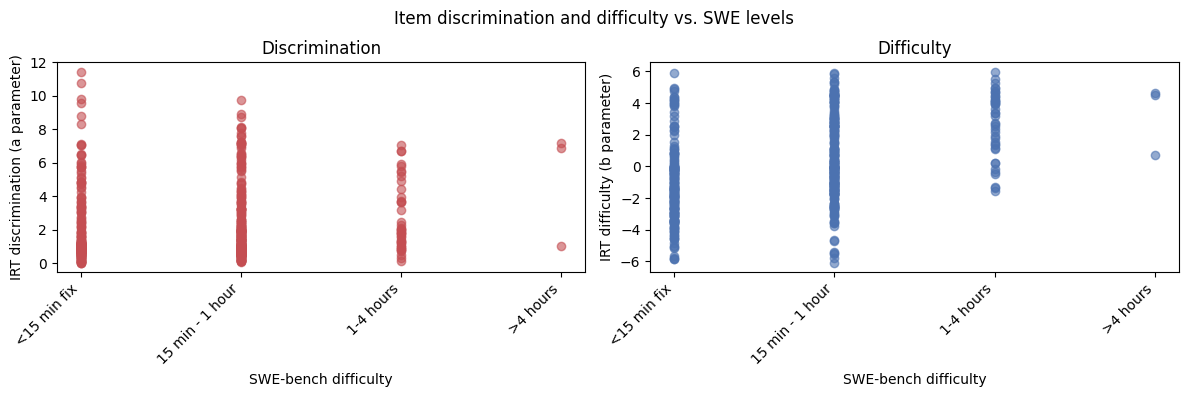

In [106]:
import csv
import matplotlib.pyplot as plt

# params_path = BASE_DIR / "params" / "swebench_all_pyirt.csv"
params_path = BASE_DIR / "params" / "swebench_selected_plus_all_runs_pyirt.csv"
a_values = []
b_values = []
difficulty_indices = []
with params_path.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        task_id = row[""]
        label = difficulty_lookup.get(task_id)
        diff_value = difficulty_to_int.get(label) if label else None
        if diff_value is None:
            continue
        difficulty_indices.append(diff_value)
        a_values.append(float(row["a"]))
        b_values.append(float(row["b"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
plt.suptitle("Item discrimination and difficulty vs. SWE levels")

axes[0].scatter(difficulty_indices, a_values, alpha=0.6, color="#C44E52")
axes[0].set_xticks(list(difficulty_to_int.values()), difficulty_levels, rotation=45, ha="right")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_ylabel("IRT discrimination (a parameter)")
axes[0].set_title("Discrimination")

axes[1].scatter(difficulty_indices, b_values, alpha=0.6, color="#4C72B0")
axes[1].set_xticks(list(difficulty_to_int.values()), difficulty_levels, rotation=45, ha="right")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_ylabel("IRT difficulty (b parameter)")
axes[1].set_title("Difficulty")

plt.tight_layout()
plt.subplots_adjust(top=0.85)



Average discrimination (a) by difficulty:
  <15 min fix: 2.024
  15 min - 1 hour: 2.226
  1-4 hours: 2.681
  >4 hours: 5.026
Average difficulty (b) by difficulty:
  <15 min fix: -1.197
  15 min - 1 hour: 0.486
  1-4 hours: 2.715
  >4 hours: 3.298


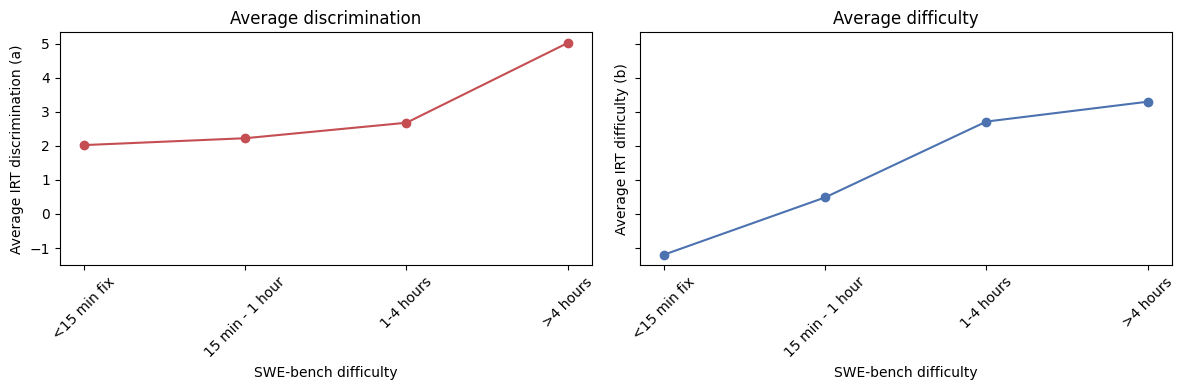

In [107]:
from collections import defaultdict
import csv
import matplotlib.pyplot as plt

# params_path = BASE_DIR / "params" / "swebench_pyirt.csv"
a_by_difficulty = defaultdict(list)
b_by_difficulty = defaultdict(list)
with params_path.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        task_id = row[""]
        label = difficulty_lookup.get(task_id)
        if not label:
            continue
        diff_key = difficulty_to_int.get(label)
        if diff_key is None:
            continue
        a_by_difficulty[label].append(float(row["a"]))
        b_by_difficulty[label].append(float(row["b"]))

ordered_labels = [label for label in difficulty_levels if label in b_by_difficulty]
globals()["a_by_difficulty"] = a_by_difficulty
globals()["b_by_difficulty"] = b_by_difficulty
globals()["ordered_labels"] = ordered_labels

a_averages = [sum(values) / len(values) for values in (a_by_difficulty[label] for label in ordered_labels)]
b_averages = [sum(values) / len(values) for values in (b_by_difficulty[label] for label in ordered_labels)]

print("Average discrimination (a) by difficulty:")
for label, avg in zip(ordered_labels, a_averages):
    print(f"  {label}: {avg:.3f}")

print("Average difficulty (b) by difficulty:")
for label, avg in zip(ordered_labels, b_averages):
    print(f"  {label}: {avg:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(ordered_labels, a_averages, marker="o", color="#C44E52")
axes[0].set_ylabel("Average IRT discrimination (a)")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_title("Average discrimination")
axes[0].tick_params(axis="x", rotation=45)

axes[1].plot(ordered_labels, b_averages, marker="o", color="#4C72B0")
axes[1].set_ylabel("Average IRT difficulty (b)")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_title("Average difficulty")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

Difficulty statistics (variance and 95% CI) for discrimination (a):
  <15 min fix: variance=4.866, mean=2.024 ± 0.310
  15 min - 1 hour: variance=4.528, mean=2.226 ± 0.258
  1-4 hours: variance=3.977, mean=2.681 ± 0.603
  >4 hours: variance=12.088, mean=5.026 ± 3.934
Difficulty statistics (variance and 95% CI) for difficulty (b):
  <15 min fix: variance=5.805, mean=-1.197 ± 0.339
  15 min - 1 hour: variance=6.369, mean=0.486 ± 0.306
  1-4 hours: variance=4.232, mean=2.715 ± 0.622
  >4 hours: variance=5.098, mean=3.298 ± 2.555


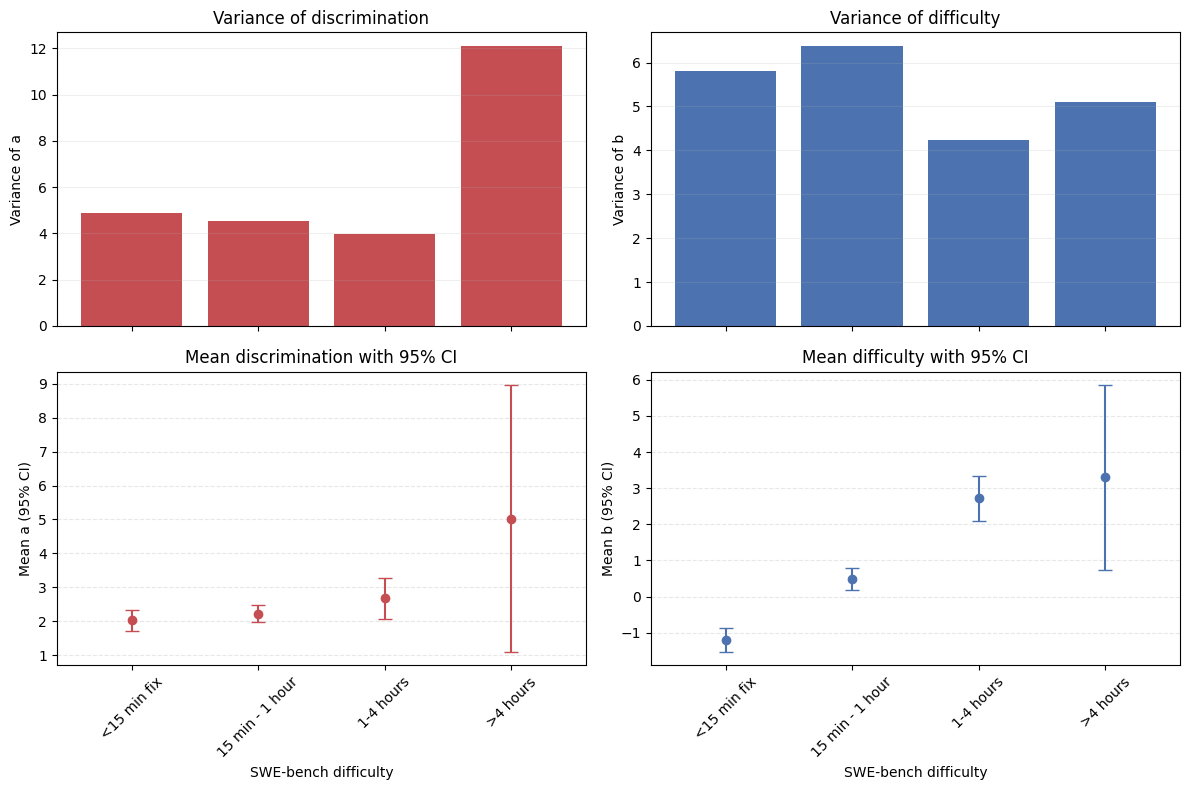

In [108]:
import math
import matplotlib.pyplot as plt

if "a_by_difficulty" not in globals() or "b_by_difficulty" not in globals():
    raise RuntimeError("Run the averaging cell first to build parameter dictionaries")

ordered = globals().get("ordered_labels") or [label for label in difficulty_levels if label in b_by_difficulty]

def compute_stats(param_map):
    stats = []
    for label in ordered:
        values = param_map[label]
        if not values:
            continue
        mean_val = sum(values) / len(values)
        if len(values) > 1:
            variance = sum((v - mean_val) ** 2 for v in values) / (len(values) - 1)
            std_error = math.sqrt(variance / len(values))
        else:
            variance = 0.0
            std_error = 0.0
        ci = 1.96 * std_error
        stats.append((label, mean_val, variance, ci))
    return stats

a_stats = compute_stats(a_by_difficulty)
b_stats = compute_stats(b_by_difficulty)

print("Difficulty statistics (variance and 95% CI) for discrimination (a):")
for label, mean_val, variance, ci in a_stats:
    print(f"  {label}: variance={variance:.3f}, mean={mean_val:.3f} ± {ci:.3f}")

print("Difficulty statistics (variance and 95% CI) for difficulty (b):")
for label, mean_val, variance, ci in b_stats:
    print(f"  {label}: variance={variance:.3f}, mean={mean_val:.3f} ± {ci:.3f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='col')

labels = [label for label, *_ in a_stats]
a_variances = [var for (_, _, var, _) in a_stats]
a_means = [mean for (_, mean, _, _) in a_stats]
a_ci = [ci for (_, _, _, ci) in a_stats]

axes[0, 0].bar(labels, a_variances, color="#C44E52")
axes[0, 0].set_ylabel("Variance of a")
axes[0, 0].set_title("Variance of discrimination")
axes[0, 0].grid(axis="y", alpha=0.2)
axes[0, 0].tick_params(axis="x", rotation=45)

axes[1, 0].errorbar(labels, a_means, yerr=a_ci, fmt="o", capsize=5, color="#C44E52")
axes[1, 0].set_ylabel("Mean a (95% CI)")
axes[1, 0].set_xlabel("SWE-bench difficulty")
axes[1, 0].set_title("Mean discrimination with 95% CI")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.3)
axes[1, 0].tick_params(axis="x", rotation=45)

labels_b = [label for label, *_ in b_stats]
b_variances = [var for (_, _, var, _) in b_stats]
b_means = [mean for (_, mean, _, _) in b_stats]
b_ci = [ci for (_, _, _, ci) in b_stats]

axes[0, 1].bar(labels_b, b_variances, color="#4C72B0")
axes[0, 1].set_ylabel("Variance of b")
axes[0, 1].set_title("Variance of difficulty")
axes[0, 1].grid(axis="y", alpha=0.2)
axes[0, 1].tick_params(axis="x", rotation=45)

axes[1, 1].errorbar(labels_b, b_means, yerr=b_ci, fmt="o", capsize=5, color="#4C72B0")
axes[1, 1].set_ylabel("Mean b (95% CI)")
axes[1, 1].set_xlabel("SWE-bench difficulty")
axes[1, 1].set_title("Mean difficulty with 95% CI")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()



/tmp/ipykernel_89764/3019234340.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(a_box_data, labels=ordered, vert=True, patch_artist=True,
/tmp/ipykernel_89764/3019234340.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(b_box_data, labels=ordered, vert=True, patch_artist=True,


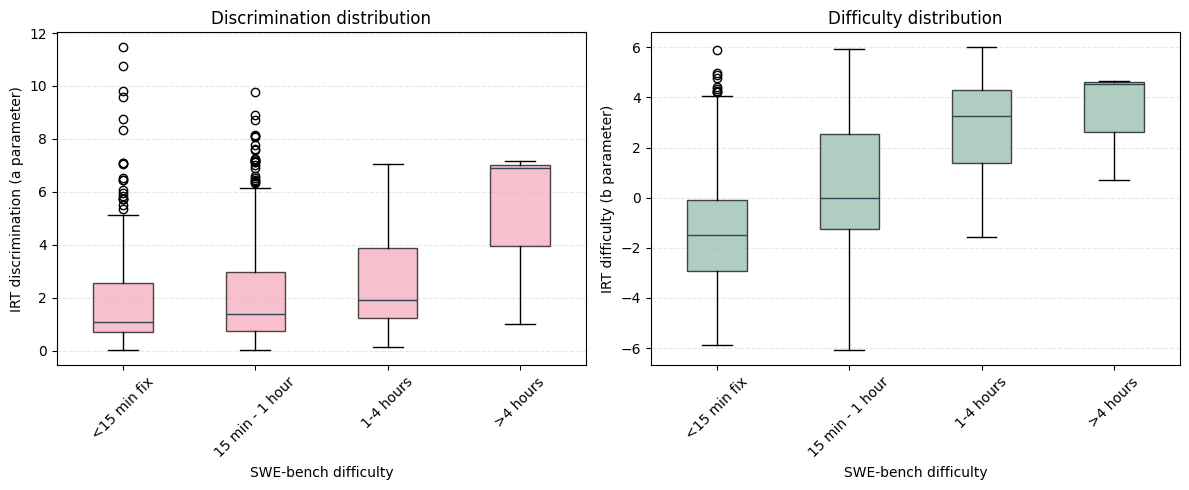

In [109]:
import matplotlib.pyplot as plt

if "a_by_difficulty" not in globals() or "b_by_difficulty" not in globals():
    raise RuntimeError("Run the averaging cell first to build parameter dictionaries")

ordered = globals().get("ordered_labels") or [label for label in difficulty_levels if label in b_by_difficulty]
a_box_data = [a_by_difficulty[label] for label in ordered]
b_box_data = [b_by_difficulty[label] for label in ordered]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].boxplot(a_box_data, labels=ordered, vert=True, patch_artist=True,
                boxprops=dict(facecolor="#F6A4B7", alpha=0.7),
                medianprops=dict(color="#2F4858"))
axes[0].set_ylabel("IRT discrimination (a parameter)")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_title("Discrimination distribution")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)
axes[0].tick_params(axis="x", rotation=45)

axes[1].boxplot(b_box_data, labels=ordered, vert=True, patch_artist=True,
                boxprops=dict(facecolor="#8FB9A8", alpha=0.7),
                medianprops=dict(color="#2F4858"))
axes[1].set_ylabel("IRT difficulty (b parameter)")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_title("Difficulty distribution")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()



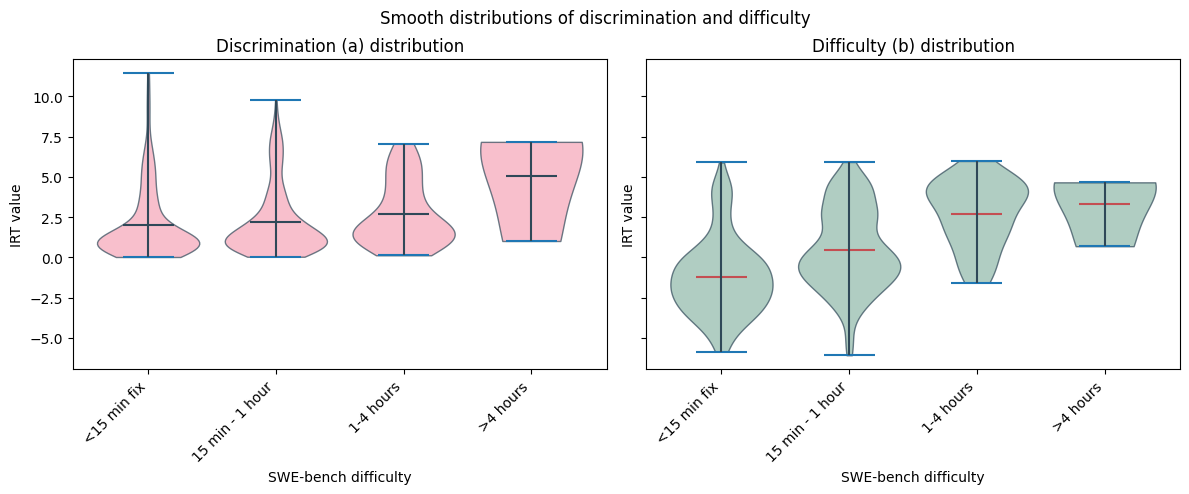

In [110]:
import matplotlib.pyplot as plt

if "a_by_difficulty" not in globals() or "b_by_difficulty" not in globals():
    raise RuntimeError("Run the averaging cell first to build parameter dictionaries")

ordered = globals().get("ordered_labels") or [label for label in difficulty_levels if label in b_by_difficulty]
a_violin_data = [a_by_difficulty[label] for label in ordered]
b_violin_data = [b_by_difficulty[label] for label in ordered]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

parts_a = axes[0].violinplot(a_violin_data, vert=True, showmeans=True, widths=0.8)
for pc in parts_a['bodies']:
    pc.set_facecolor("#F6A4B7")
    pc.set_edgecolor("#2F4858")
    pc.set_alpha(0.7)
parts_a['cbars'].set_color("#2F4858")
parts_a['cmeans'].set_color("#2F4858")
axes[0].set_xticks(range(1, len(ordered) + 1), ordered, rotation=45, ha="right")
axes[0].set_ylabel("IRT value")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_title("Discrimination (a) distribution")

parts_b = axes[1].violinplot(b_violin_data, vert=True, showmeans=True, widths=0.8)
for pc in parts_b['bodies']:
    pc.set_facecolor("#8FB9A8")
    pc.set_edgecolor("#2F4858")
    pc.set_alpha(0.7)
parts_b['cbars'].set_color("#2F4858")
parts_b['cmeans'].set_color("#C44E52")
axes[1].set_xticks(range(1, len(ordered) + 1), ordered, rotation=45, ha="right")
axes[1].set_ylabel("IRT value")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_title("Difficulty (b) distribution")

plt.suptitle("Smooth distributions of discrimination and difficulty")
plt.tight_layout()
plt.subplots_adjust(top=0.88)

